In [1]:
import torch.nn as nn
import torch
import pandas as pd

In [115]:
class NeuralNetwork(nn.Module):
    """
    Neural Network Class for implementing neural networks for different loss and optimization functions.
    
    Attributes:
        input_size: An integer indicating number of input features.
        output_size: An integer indicating size of output.
        hidden_layer_size: An integer indicating size of hidden layer.
        
        w1: A vector (input_size X hidden_layers_sizes[0]) of floats required for training the neural network.
        wn: A vector (hidden_layers_sizes[-1] X output_size) for weights of final layer.
        
        activations: An array of strings indicating the activation functions for every layer.
        loss: A string indicating the loss function for the neural network.
        optimizer: A string indicating the optimization algorithm to be used to train the network.
    """
    def __init__(self, input_size, output_size, hidden_layer_size, activations, loss, optimizer):
        """
        Initializes Neural Network class attributes.
        
        Args:
            input_size (int): Number of features of the input.
            output_size (int): Dimension of output.
            hidden_layer_size (int): Number of neurons in the input layer.
            activations (list): List of strings giving the activations for each layer.
            loss (str): Loss function for the model.
            optimizer (str): Optimization algorithm for the model.
        """
        super(NeuralNetwork, self)
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_layer_size = hidden_layer_size
        
        self.w1 = torch.randn(self.input_size, self.hidden_layer_size, dtype=torch.double)
        self.wn = torch.randn(self.hidden_layer_size, self.output_size, dtype=torch.double)
    
        self.activations = activations
        self.loss = loss
        self.optimizer = optimizer
    
    
    def forward(self, X, w1=None, wn=None):
        """
        Forward pass of the neural network.
        
        Args:
            X (tensor): Input for the model. 
            w1 (tensor): Weights to be used for the first layer. (Optional Argument)
            wn (tensor): Weights to be used for the final layer. (Optional Argument)
            
        Returns:
            z (list): List of outputs from linear function at each layer.
            a (list): List of activation outputs from each layer.
        """
        if w1 is None:
            w1 = self.w1
        if wn is None:
            wn = self.wn
        z = []
        a = []
        z.append(torch.matmul(X, w1))
        a.append(self.evaluateActivation(self.activations[0])(z[-1]))
        z.append(torch.matmul(a[-1], wn))
        a.append(self.evaluateActivation(self.activations[1])(z[-1]))
        return z, a
    
    
    def backward(self, X, y, z, a, wn=None):
        """
        Backward Pass of the model.
        
        Args:
            X (Tensor): Input Data
            y (Tensor): Output Data
            z (list): List of outputs from linear layers.
            a (list): List of actiation outputs.
            wn (Tensor): Weights from final layer. (Optional Argument)
        """
        if wn is None:
            wn = self.wn
        dW = []
        dL_da_n = self.evaluateLossDerivative()(a[-1], y)
        da_n_dz_n = self.evaluateActivationDerivative(self.activations[1])(z[-1])
        dz_n_dWn = a[0]
        dL_dWn = torch.matmul(dz_n_dWn.T, (dL_da_n * da_n_dz_n))
        
        dz_n_da_1 = wn
        da_1_dz_1 = self.evaluateActivationDerivative(self.activations[0])(z[0])
        dz_1_dW1 = X
        dL_dW1 = torch.matmul(dz_1_dW1.T, (torch.matmul(dL_da_n * da_n_dz_n, dz_n_da_1.T)*da_1_dz_1))
        dW.append(dL_dW1)
        dW.append(dL_dWn)
        return dW
    
    
    def train(self, X, y, batch_size=100, iterations=500, alpha=1e-05, momentum_param=0, nesterov=False, decay_rate=0.999, beta1=0.9, beta2=0.999):
        """
        Function to train the neural network.
        """
        funVals = []
        ypred = None
        if self.optimizer == 'SGD':
            if momentum_param != 0:
                if nesterov:
                    funVals ,ypred = self.SGD(X, y, batch_size, iterations, alpha, momentum_param, True)
                else:
                    funVals, ypred = self.SGD(X, y, batch_size, iterations, alpha, momentum_param)
            else:
                funVals, ypred = self.SGD(X, y, batch_size, iterations, alpha)
        elif self.optimizer == 'Adagrad':
            funVals, ypred = self.Adagrad(X, y, batch_size, iterations, alpha)
        elif self.optimizer == 'RMSProp':
            funVals, ypred = self.RMSProp(X, y, batch_size, iterations, alpha, decay_rate)
        elif self.optimizer == 'Adam':
            funVals, ypred = self.Adam(X, y, batch_size, iterations, alpha, beta1, beta2)
        return funVals, ypred
    
    
    def SGD(self, X, y, batch_size=100, iterations=500, alpha=1e-05, momentum_param=0, nesterov=False):
        """
        Gradient Descent Algorithm
        """
        m, n = X.shape
        funVals = []
        ypred = []
        v1 = torch.zeros(self.w1.shape, dtype=torch.double)
        vn = torch.zeros(self.wn.shape, dtype=torch.double)
        n_iter = 0
        flag = True
        while flag:
            for i in range(m//batch_size):
                n_iter += 1
                if nesterov:
                    z, a = self.forward(X[i:i+batch_size], self.w1+momentum_param*v1, self.wn+momentum_param*vn)
                    dW = self.backward(X[i:i+batch_size], y[i:i+batch_size], z, a, self.wn+momentum_param*vn)
                else:
                    z, a = self.forward(X[i:i+batch_size])
                    dW = self.backward(X[i:i+batch_size], y[i:i+batch_size], z, a)
                v1 = momentum_param * v1 - alpha * dW[0]
                vn = momentum_param * vn - alpha * dW[1]
                self.w1 = self.w1 + v1
                self.wn = self.wn + vn
                if n_iter>iterations:
                    flag = False
                    break
                if n_iter%batch_size == 0:
                    ypred = self.predict(X)
                    funVals.append((self.evaluateLoss()(ypred, y)).item())
                    print(n_iter, funVals[-1])
            W = torch.cat([self.w1.flatten().reshape(-1, 1), self.wn.reshape(-1,1)])
            optCond = torch.matmul(W.T, W)
            if optCond < 1e-2 or n_iter>iterations:
                break
            ypred = self.predict(X)
            funVals.append((self.evaluateLoss()(ypred, y)).item())
            print(n_iter, funVals[-1])
        ypred = self.predict(X)
        if self.loss == 'CELoss':
            ypred = self.softmax(ypred)
        return funVals, ypred
    
    
    def Adagrad(self, X, y, batch_size=100, iterations=500, alpha=1e-5):
        """
        AdaGrad Optimizer
        """
        m, n = X.shape
        funVals = []
        ypred = []
        n_iter = 0
        flag = True
        smoothing_param = 1e-8
        cache1 = torch.zeros(self.w1.shape, dtype=torch.double)
        cache2 = torch.zeros(self.wn.shape, dtype=torch.double)
        while flag:
            for i in range(m//batch_size):
                n_iter += 1
                z, a = self.forward(X[i:i+batch_size])
                dW = self.backward(X[i:i+batch_size], y[i:i+batch_size], z, a)
                cache1 += dW[0]**2
                cache2 += dW[1]**2
                self.w1 += -(alpha/(torch.sqrt(cache1)+smoothing_param)) * dW[0]
                self.wn += -(alpha/(torch.sqrt(cache2)+smoothing_param)) * dW[1]
                if n_iter>iterations:
                    flag = False
                    break
                if n_iter%batch_size == 0:
                    ypred = self.predict(X)
                    funVals.append((self.evaluateLoss()(ypred, y)).item())
                    print(n_iter, funVals[-1])
            W = torch.cat([self.w1.flatten().reshape(-1, 1), self.wn.reshape(-1,1)])
            optCond = torch.matmul(W.T, W)
            if optCond < 1e-2 or n_iter>iterations:
                break
            ypred = self.predict(X)
            funVals.append((self.evaluateLoss()(ypred, y)).item())
            print(n_iter, funVals[-1])
        ypred = self.predict(X)
        if self.loss == 'CELoss':
            ypred = self.softmax(ypred)
        return funVals, ypred
    
    
    def RMSProp(self, X, y, batch_size=100, iterations=500, alpha=1e-04, decay_rate=0.999):
        """
        RMSProp Optimizer.
        """
        m, n = X.shape
        funVals = []
        ypred = []
        n_iter = 0
        flag = True
        smoothing_param = 1e-8
        cache1 = torch.zeros(self.w1.shape, dtype=torch.double)
        cache2 = torch.zeros(self.wn.shape, dtype=torch.double)
        while flag:
            for i in range(m//batch_size):
                n_iter += 1
                z, a = self.forward(X[i:i+batch_size])
                dW = self.backward(X[i:i+batch_size], y[i:i+batch_size], z, a)
                cache1 = decay_rate*cache1 + (1 - decay_rate) * dW[0]**2
                cache2 += dW[1]**2
                self.w1 += -(alpha/(torch.sqrt(cache1+smoothing_param))) * dW[0]
                self.wn += -(alpha/(torch.sqrt(cache2+smoothing_param))) * dW[1]
                if n_iter>iterations:
                    flag = False
                    break
                if n_iter%batch_size == 0:
                    ypred = self.predict(X)
                    funVals.append((self.evaluateLoss()(ypred, y)).item())
                    print(n_iter, funVals[-1])
            W = torch.cat([self.w1.flatten().reshape(-1, 1), self.wn.reshape(-1,1)])
            optCond = torch.matmul(W.T, W)
            if optCond < 1e-2 or n_iter>iterations:
                break
            ypred = self.predict(X)
            funVals.append((self.evaluateLoss()(ypred, y)).item())
            print(n_iter, funVals[-1])
        ypred = self.predict(X)
        if self.loss == 'CELoss':
            ypred = self.softmax(ypred)
        return funVals, ypred
    
    
    def Adam(self, X, y, batch_size=100, iterations=500, alpha=1e-04, beta1=0.9, beta2=0.999):
        """
        Adam Optimizer
        """
        m, n = X.shape
        funVals = []
        ypred = []
        n_iter = 0
        flag = True
        smoothing_param = 1e-8
        m1 = torch.zeros(self.w1.shape, dtype=torch.double)
        m2 = torch.zeros(self.wn.shape, dtype=torch.double)
        v1 = torch.zeros(self.w1.shape, dtype=torch.double)
        v2 = torch.zeros(self.wn.shape, dtype=torch.double)
        while flag:
            for i in range(m//batch_size):
                n_iter += 1
                z, a = self.forward(X[i:i+batch_size])
                dW = self.backward(X[i:i+batch_size], y[i:i+batch_size], z, a)
                m1 = beta1 * m1 + (1-beta1) * dW[0]
                v1 = beta2 * v1 + (1-beta2) * dW[0]**2
                m2 = beta1 * m2 + (1-beta1) * dW[1]
                v2 = beta2 * v2 + (1-beta2) * dW[1]**2
                self.w1 += -alpha*(m1/(1-beta1**n_iter))/(torch.sqrt((v1)/(1-beta2**n_iter)) + smoothing_param)
                self.wn += -alpha*(m2/(1-beta1**n_iter))/(torch.sqrt((v2)/(1-beta2**n_iter)) + smoothing_param)
                if n_iter>iterations:
                    flag = False
                    break
                if n_iter%batch_size == 0:
                    ypred = self.predict(X)
                    funVals.append((self.evaluateLoss()(ypred, y)).item())
                    print(n_iter, funVals[-1])
            W = torch.cat([self.w1.flatten().reshape(-1, 1), self.wn.reshape(-1,1)])
            optCond = torch.matmul(W.T, W)
            if optCond < 1e-2 or n_iter>iterations:
                break
            ypred = self.predict(X)
            funVals.append((self.evaluateLoss()(ypred, y)).item())
            print(n_iter, funVals[-1])
        ypred = self.predict(X)
        if self.loss == 'CELoss':
            ypred = self.softmax(ypred)
        return funVals, ypred
    
    
    def predict(self, X):
        """
        Predict function
        """
        _, a = self.forward(X)
        return a[-1]
    
    
    def reset_weights(self):
        """
        Reset Weights
        """
        self.w1 = torch.randn(self.input_size, self.hidden_layer_size, dtype=torch.double)
        self.wn = torch.randn(self.hidden_layer_size, self.output_size, dtype=torch.double)
    
    
    def evaluateActivation(self, activation):
        """
        Activation function
        """
        if activation == 'sigmoid' :
            def sigmoid(z):
                s = torch.exp(-z)
                return 1/(1+s)
            return sigmoid
#             return lambda z : torch.exp(z)/(1 + torch.exp(z))
        elif activation == 'relu':
            def relu(z):
                z1 = torch.clone(z)
                return z1.clamp(min=0)
            return relu
        elif activation == 'tanh':
            return lambda z : (2/(1+torch.exp(-2*z))) - 1
        return lambda z : z
    
    
    def evaluateActivationDerivative(self, activation):
        """
        Derivative of Activation Function
        """
        if activation == 'sigmoid':
            sigmoid = lambda z : 1/(1 + torch.exp(-z))
            return lambda z : sigmoid(z) * (1 - sigmoid(z))
        elif activation == 'relu':
            def relu_derivative(z):
                z1 = torch.clone(z)
                z1[z>=0] = 1
                z1[z<0] = 0
                return z1
            return relu_derivative
        elif activation == 'tanh':
            tanh = lambda z : (2/(1+torch.exp(-2*z))) - 1
            return lambda z : 1 - tanh(z)**2
        return lambda z : 1
    
    
    def evaluateLoss(self):
        """
        Loss Function
        """
        if self.loss == 'MSE':
            return lambda ypred, y : torch.matmul((ypred - y).T, (ypred - y))/(2*len(y))
        elif self.loss == 'BCELoss':
            def binaryCrossEntropyLoss(ypred, y):
                loss = torch.sum(torch.log(ypred[y==1])) + torch.sum(torch.log(1 - ypred[y==0]))
                return -loss/y.shape[0]
            return binaryCrossEntropyLoss
#             return lambda ypred, y : (-1/len(y))*(torch.matmul(y.T, torch.log(ypred)) + torch.matmul((1-y).T, torch.log(1-ypred)))
            return binaryCrossEntropyLoss
        elif self.loss == "CELoss":
            def crossEntropyLoss(ypred, y):
                m = y.shape[0]
                prob = self.softmax(ypred)
                log_likelihood = -torch.log(prob[range(m), y.long()])
                loss = torch.sum(log_likelihood)
                return loss/m
            return crossEntropyLoss
        return lambda x : 1
    
    
    def evaluateLossDerivative(self):
        """
        Loss function Derivative
        """
        if self.loss == 'MSE':
            return lambda ypred, y: (ypred - y)/len(y)
        elif self.loss == 'BCELoss':
            return lambda ypred, y: (-1/len(y)) * ((y/ypred) - ((1-y)/(1-ypred)))
        elif self.loss == 'CELoss':
            def crossEntropyLossGradient(ypred, y):
                m = y.shape[0]
                grad = self.softmax(ypred)
                grad[range(m), y.long()] -= 1
                return grad/m
            return crossEntropyLossGradient
        return lambda x : 1
    
    
    def softmax(self, z):
        exps = torch.exp(z - (torch.max(z, dim=1).values.reshape(-1,1)))
        return exps/torch.sum(exps, dim=1).reshape(-1, 1)

In [45]:
# X = torch.rand(312, 20, dtype=torch.double)
# y = torch.randint(0, 2,(312, 1)).double()
# y = torch.randn(312, 1, dtype=torch.double)
# y = torch.randint(0,3,(312, 1)).double()

In [76]:
# model_temp = NeuralNetwork(X.shape[1], 1, 32, ['relu', 'sigmoid'], 'BCELoss', 'Adam')

In [ ]:
# funVals, ypred = model_temp.train(X, y, batch_size=100, iterations=1000, alpha=1e-03)

In [ ]:
# print((torch.sum(ypred.argmax(dim=1).reshape(-1,1) == y.long()).float()*100.0)/(y.shape[0]))

In [ ]:
# %matplotlib inline
# def plotLoss(funVals, filePath, title):
# import matplotlib.pyplot as plt
# plt.plot([i for i in range(1, len(funVals)+1)], funVals)
# plt.xlabel("Number of Iterations")
# plt.ylabel("Loss")

In [3]:
%matplotlib inline
def plotLoss(funVals, filePath=None, title="", plot=False):
    import matplotlib.pyplot as plt
    plt.plot([i for i in range(1, len(funVals)+1)], funVals)
    plt.xlabel("Number of Iterations")
    plt.ylabel("Loss")
    plt.title(title)
    if not plot:
        plt.show()
    else:
        plt.savefig("./dataset/"+filePath)

In [ ]:
def loadAutoMPGDataset():
    import pandas as pd
    auto_mpg_dataset = pd.read_csv("./dataset/auto-mpg/auto-mpg.data", header=-1, comment='\t', skipinitialspace=True, na_values='?', sep=' ')
    auto_mpg_dataset = auto_mpg_dataset.dropna()
    origin = auto_mpg_dataset.pop(7)
    auto_mpg_dataset[7] = (origin==1)*1.0
    auto_mpg_dataset[8] = (origin==2)*1.0
    auto_mpg_dataset[9] = (origin==3)*1.0
    auto_dataset = torch.tensor(auto_mpg_dataset.values, dtype=torch.double)
    return auto_dataset

In [ ]:
auto_dataset = loadAutoMPGDataset()
auto_dataset = auto_dataset[torch.randperm(auto_dataset.shape[0])]

In [ ]:
train = auto_dataset[:int(0.8 * auto_dataset.shape[0])]
test = auto_dataset[int(0.8 * auto_dataset.shape[0]):]

Xtrain = train[:, 1:]
Xtrain = (Xtrain - Xtrain.mean(dim=0))/Xtrain.std(dim=0)
ytrain = train[:, 0].reshape(-1, 1)

Xtest = test[:, 1:]
Xtest = (Xtest - Xtest.mean(dim=0))/Xtest.std(dim=0)
ytest = test[:, 0].reshape(-1, 1)

In [ ]:
auto_mpg_model = NeuralNetwork(Xtrain.shape[1], ytrain.shape[1], 64, ['relu', 'relu'], 'MSE', 'Adam')

In [ ]:
# auto_mpg_model.reset_weights()

In [ ]:
funVals, ypred = auto_mpg_model.train(Xtrain, ytrain, batch_size=100, iterations=1000, alpha=1e-03)

In [ ]:
plotLoss(funVals)

In [ ]:
def loadIrisDataset():
    iris_dataset = pd.read_csv("./dataset/iris/iris.data", header=-1)
    iris_dataset[4] = iris_dataset[4].astype('category').cat.codes
    iris_dataset = torch.tensor(iris_dataset.values, dtype=torch.double)
    return iris_dataset

In [ ]:
iris_dataset = loadIrisDataset()
iris_dataset = iris_dataset[torch.randperm(iris_dataset.shape[0])]

In [ ]:
train_iris = iris_dataset[:int(0.8 * iris_dataset.shape[0])]
test_iris = iris_dataset[int(0.8 * iris_dataset.shape[0]):]

Xtrain_iris = train_iris[:, :-1]
Xtrain_iris = (Xtrain_iris - Xtrain_iris.mean(dim=0))/Xtrain_iris.std(dim=0)
ytrain_iris = train_iris[:, -1].reshape(-1, 1)

Xtest_iris = test_iris[:, :-1]
Xtest_iris = (Xtest_iris - Xtest_iris.mean(dim=0))/Xtest_iris.std(dim=0)
ytest_iris = test_iris[:, -1].reshape(-1, 1)

In [ ]:
iris_model = NeuralNetwork(Xtrain_iris.shape[1], 3, 64, ['relu', 'linear'], 'CELoss', 'Adam')

In [ ]:
funVals, ypred = iris_model.train(Xtrain_iris, ytrain_iris, batch_size=100, iterations=500, alpha=1e-03)

In [ ]:
plotLoss(funVals)

In [ ]:
print(torch.sum(torch.argmax(ypred, dim=1).reshape(-1,1) == ytrain_iris.long()))

In [ ]:
print(ytrain_iris.shape)

In [ ]:
model = nn.Sequential(nn.Linear(Xtrain_iris.shape[1], 32), 
                      nn.ReLU(),
                      nn.Linear(32, 3))

In [ ]:
lossFn = nn.CrossEntropyLoss()

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-03)

In [ ]:
fval = []
for epoch in range(1000):
    for i in range(Xtrain_iris.shape[0]//100):
        optimizer.zero_grad()
        yp = model(Xtrain_iris[i:i+100].float())
        loss = lossFn(yp, ytrain_iris[i:i+100].long()[:, 0])
        loss.backward()
        optimizer.step()
        fval.append(loss.item())

In [ ]:
plotLoss(fval)

In [ ]:
print(fval)

In [4]:
def loadBreastCancerDataset():
    cancer_dataset = pd.read_csv("./dataset/breast-cancer/data.csv")
    cancer_dataset.drop(['Unnamed: 32', 'id'], axis=1, inplace=True)
    cancer_dataset['diagnosis'] = cancer_dataset['diagnosis'].astype('category').cat.codes
    cancer_dataset = torch.tensor(cancer_dataset.values, dtype=torch.double)
    return cancer_dataset

In [5]:
cancer_dataset = loadBreastCancerDataset()
cancer_dataset = cancer_dataset[torch.randperm(cancer_dataset.shape[0])]

In [66]:
train_cancer = cancer_dataset[:int(0.8*cancer_dataset.shape[0])]
test_cancer = cancer_dataset[int(0.8*cancer_dataset.shape[0]):]

Xtrain_cancer = train_cancer[:, 1:]
Xtrain_cancer = (Xtrain_cancer-Xtrain_cancer.mean(dim=0))/Xtrain_cancer.std(dim=0)
ytrain_cancer = train_cancer[:, 0].reshape(-1, 1)

Xtest_cancer = test_cancer[:, 1:]
Xtest_cancer = (Xtest_cancer-Xtest_cancer.mean(dim=0))/Xtest_cancer.std(dim=0)
ytest_cancer = test_cancer[:, 0].reshape(-1, 1)


In [182]:
cancer_model = NeuralNetwork(Xtrain_cancer.shape[1], 1, 16, ['relu', 'sigmoid'], 'BCELoss', 'Adam')

In [183]:
funVals, ypred = cancer_model.train(Xtrain_cancer, ytrain_cancer, batch_size=100, iterations=1000, alpha=1e-03)

4 1.1721434012905105
8 1.1178754404790323
12 1.0662013436637188
16 1.0168211871912642
20 0.9696337439568992
24 0.9245751857149923
28 0.8814975635373248
32 0.8403259386395664
36 0.8010763855887729
40 0.7637546927970412
44 0.7284250540449979
48 0.6950577953538213
52 0.6635239382882988
56 0.6335779355162863
60 0.6050241003985053
64 0.5775496081566854
68 0.5512745342179106
72 0.526096018222431
76 0.5021602283175242
80 0.47965223719668076
84 0.458584680274452
88 0.43905153909234
92 0.4209687280227108
96 0.40431992297347386
100 0.3890098470422621
100 0.3890098470422621
104 0.37503220164519463
108 0.36222580726188325
112 0.3504515762107168
116 0.3394795814711981
120 0.32947307930069014
124 0.3203146872834864
128 0.3119139892918546
132 0.3041941815493446
136 0.29711313706637626
140 0.29056634857273267
144 0.2845123987230874
148 0.27889132741932793
152 0.2736878280507816
156 0.2688256398394953
160 0.26426133365519106
164 0.2599923696880881
168 0.2560352270559661
172 0.2523241849041017
176 0.248

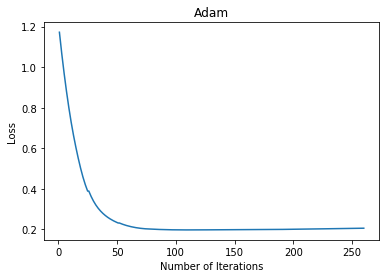

In [184]:
plotLoss(funVals, filePath="breast-cancer/results/Adam", title="Adam", plot=True)

In [ ]:
print(cancer_model.w1)